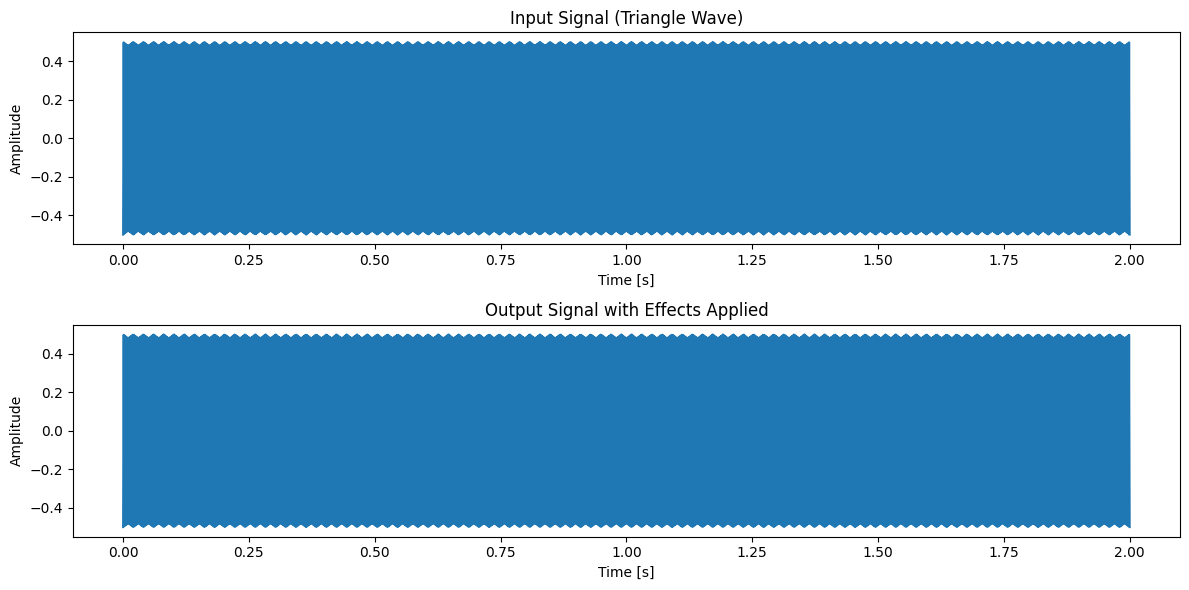

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, wet_dry=1, *args):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, wet_dry, args))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def soft_clipping(self, x, T):
        return T * np.tanh(x / T)
    
    def variable_saturation(self, x, T, a, b, D):
        return T * (np.abs(D * x + b / T) ** a) * np.sign(D * x + b)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, wet_dry, args in self.effects:
            if wet_dry == 1:
                output_signal = effect_func(output_signal, *args)
        return output_signal

# Example of using the EffectRack class
if __name__ == "__main__":
    # Generate a test signal (triangle wave)
    sample_rate = 44100
    t = np.linspace(0, 0.1, sample_rate)
    input_signal = 0.5 * sawtooth(2 * np.pi * 440 * t, 0.5)  # 440 Hz triangle wave
    
    # Create an EffectRack instance
    effect_rack = EffectRack()
    
    # Add hard clipping effect with wet/dry = 1 (effect applied)
    #effect_rack.add_effect(effect_rack.hard_clipping, 1, 0.3)
    
    # Add soft clipping effect with wet/dry = 0 (effect not applied)
    #effect_rack.add_effect(effect_rack.soft_clipping, 0, 0.3)
    
    # Add variable saturation effect with wet/dry = 1 (effect applied)
    #effect_rack.add_effect(effect_rack.variable_saturation, 1, 0.5, 2, 0.1, 1.5)
    
    # Add compression effect with wet/dry = 0 (effect not applied)
    #effect_rack.add_effect(effect_rack.compressor, 0, -20, 2, 0.01, 0.1, sample_rate, 100)
    
    # Apply all effects to the input signal
    


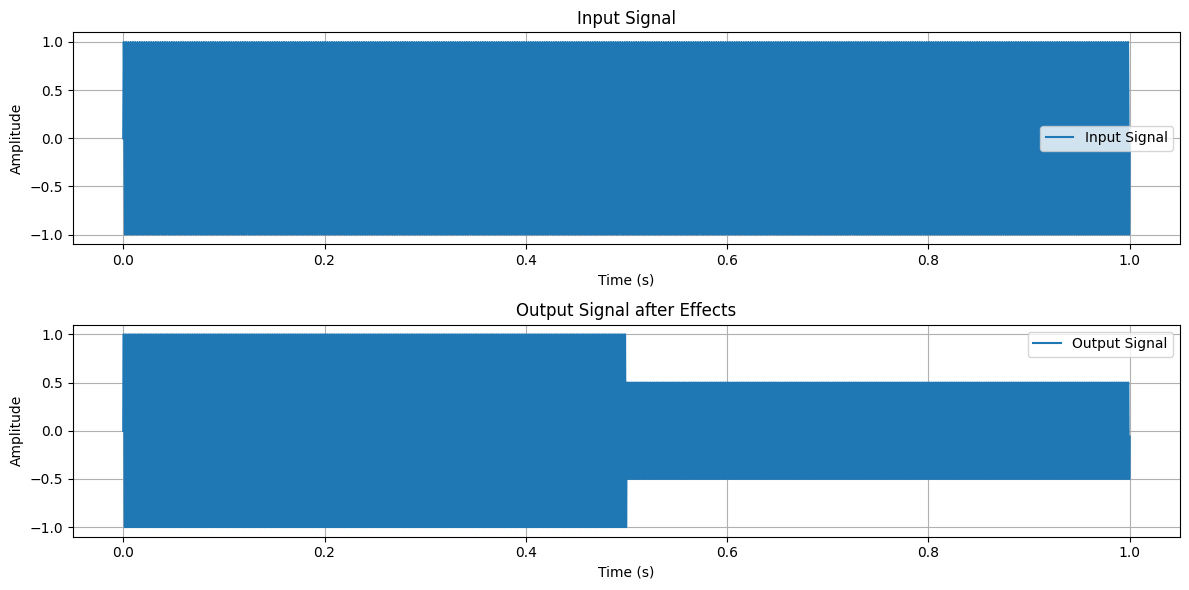

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, *args, wet_dry=1):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, args, wet_dry))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    @staticmethod
    def delay_system(input_signal, base_delay_samples, lfo_signal=None, lfo_depth=0):
        output_signal = np.zeros_like(input_signal)
        max_delay = base_delay_samples + int(lfo_depth * np.max(np.abs(lfo_signal))) if lfo_signal is not None else base_delay_samples
        buffer = np.zeros(len(input_signal) + max_delay)
        buffer[:len(input_signal)] = input_signal
        
        for i in range(len(input_signal)):
            delay = base_delay_samples
            if lfo_signal is not None:
                delay += int(lfo_depth * lfo_signal[i])
            if delay < 0:
                delay = 0
            output_signal[i] = input_signal[i] + buffer[i + delay]
            buffer[i + delay] = output_signal[i]

        return output_signal
    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, args, wet_dry in self.effects:
            if wet_dry == 1:
                output_signal = effect_func(output_signal, *args)
        return output_signal
    
    @staticmethod
    def generate_lfo(sample_rate, duration, frequency, depth):
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        lfo_signal = np.sin(2 * np.pi * frequency * t) * depth
        return lfo_signal

# تست با یک سیگنال ورودی
sample_rate = 44100
duration = 1  # ثانیه
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
input_signal = np.sin(2 * np.pi * 440 * t)  # سیگنال ورودی، در اینجا یک سینوس 440 هرتز

# ایجاد یک EffectRack جدید
rack = EffectRack()

# افزودن افکت هارد کلیپینگ به عنوان یکی از افکت‌ها
rack.add_effect(rack.hard_clipping, 0.5, wet_dry=1)  # T=0.5 به عنوان یکی از آرگومان‌های افکت

# تولید سیگنال LFO
frequency = 1  # فرکانس LFO (هرتز)
depth = 0.5  # عمق LFO
lfo_signal = rack.generate_lfo(sample_rate, duration, frequency, depth)

# افزودن افکت دیلی با پارامترهای مختلف به عنوان یکی از افکت‌ها
base_delay_samples = int(0.5 * sample_rate)  # 0.5 ثانیه تاخیر
rack.add_effect(EffectRack.delay_system, base_delay_samples, lfo_signal, 1.0, wet_dry=1)

# اعمال افکت‌ها و دریافت سیگنال خروجی
output_signal = rack.apply_effects(input_signal)

# رسم نمودار ورودی و خروجی
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, input_signal, label='Input Signal')
plt.title('Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, output_signal, label='Output Signal')
plt.title('Output Signal after Effects')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


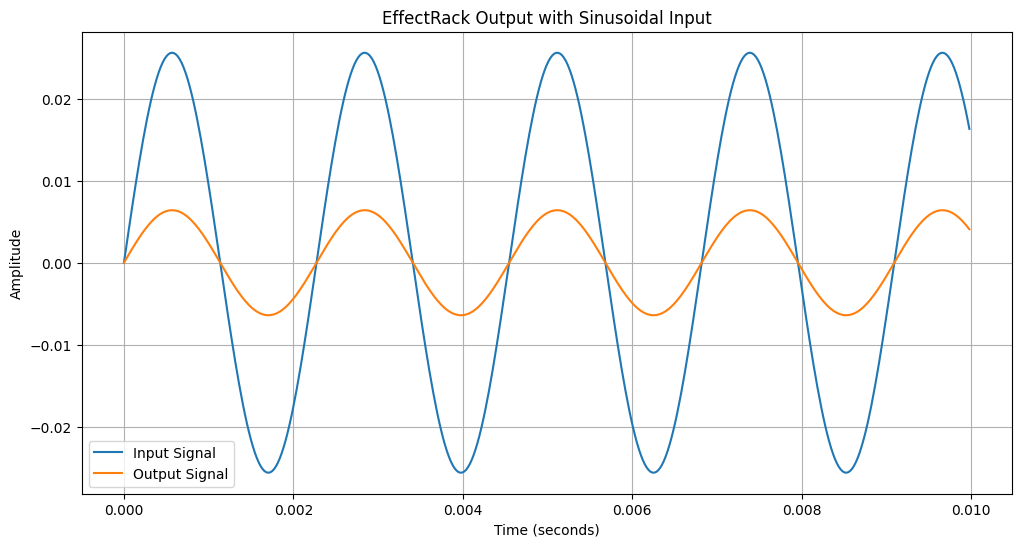

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, *args, wet_dry=1):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, args, wet_dry))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    @staticmethod
    def delay_system(input_signal, base_delay_samples, lfo_signal=None, lfo_depth=0):
        output_signal = np.zeros_like(input_signal)
        max_delay = base_delay_samples + int(lfo_depth * np.max(np.abs(lfo_signal))) if lfo_signal is not None else base_delay_samples
        buffer = np.zeros(len(input_signal) + max_delay)
        buffer[:len(input_signal)] = input_signal
        
        for i in range(len(input_signal)):
            delay = base_delay_samples
            if lfo_signal is not None:
                delay += int(lfo_depth * lfo_signal[i])
            if delay < 0:
                delay = 0
            output_signal[i] = input_signal[i] + buffer[i + delay]
            buffer[i + delay] = output_signal[i]

        return output_signal
    
    @staticmethod
    def phaser(audio, sample_rate, *args):
        # Unpack args
        rate = args[0] if len(args) > 0 else 0.5
        depth = args[1] if len(args) > 1 else 1
        feedback = args[2] if len(args) > 2 else 0.5
        n_stages = args[3] if len(args) > 3 else 4

        lfo = depth * np.sin(2 * np.pi * rate * np.arange(len(audio)) / sample_rate) 
        # Precalculate all possible delays based on the LFO
        max_delay = int(sample_rate / 4)
        all_delays = np.round((0.5 + 0.5 * lfo) * max_delay).astype(int)

        allpass_g = feedback

        for stage in range(n_stages):  
            # Create coefficients for the allpass filter
            a0 = (1 - allpass_g) / (1 + allpass_g)
            b = [a0, 1]
            a = [1, a0]

            # Apply allpass filter with the corresponding delay for each sample
            filtered_audio = np.zeros_like(audio)  # Initialize the filtered audio array
            for i, delay in enumerate(all_delays):
                delayed_sample = audio[max(0, i - delay)]
                filtered_audio[i] = lfilter(b, a, [delayed_sample])[0]

            # Mix the filtered signal with the original signal
            audio += filtered_audio

        return audio / n_stages
    @staticmethod
    def flanger(signal, sample_rate, delay, depth, rate, feedback=0):
        """
        Flanger effect.

        Parameters:
            signal (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delay (float): Base delay time in seconds.
            depth (float): Depth of modulation in seconds.
            rate (float): Rate of LFO in Hz.
            feedback (float): Feedback amount.

        Returns:
            numpy array: Audio signal with flanger effect.
        """
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = depth_samples * (1 + np.sin(2 * np.pi * rate * np.arange(N) / sample_rate)) / 2
        flanged_signal = np.zeros(N)
        feedback_buffer = np.zeros(N)

        for n in range(N):
            delay_n = int(lfo[n])
            if n - delay_samples - delay_n < 0:
                flanged_signal[n] = signal[n]
            else:
                flanged_signal[n] = signal[n] + feedback * feedback_buffer[n - delay_samples - delay_n]
                feedback_buffer[n] = flanged_signal[n]

        return flanged_signal    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, args, wet_dry in self.effects:
            if wet_dry == 1:
                output_signal = effect_func(output_signal, *args)
        return output_signal
    
    @staticmethod
    def generate_lfo(sample_rate, duration, frequency, depth):
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        lfo_signal = np.sin(2 * np.pi * frequency * t) * depth
        return lfo_signal

# Test with sinusoidal signal
sample_rate = 44100  # Sample rate in Hz
duration = 0.01  # Duration in seconds
frequency = 440  # Frequency in Hz
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
input_signal = np.sin(2 * np.pi * frequency * t)

# Instantiate EffectRack
rack = EffectRack()

# Add effects to the rack
#rack.add_effect(rack.hard_clipping, 0.5, wet_dry=1)
#rack.add_effect(rack.compressor, -20, 4, 0.1, 0.1, sample_rate, 100, wet_dry=1)
#rack.add_effect(rack.delay_system, sample_rate // 4, rack.generate_lfo(sample_rate, duration, 0.2, 0.5), 0.5, wet_dry=1)
rack.add_effect(rack.phaser, 0.2, 0.5, 0.5, 4, wet_dry=1)  # Adjust arguments accordingly

# Apply effects
output_signal = rack.apply_effects(input_signal)

# Plot input and output signals
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label='Input Signal')
plt.plot(t, output_signal, label='Output Signal')
plt.title('EffectRack Output with Sinusoidal Input')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


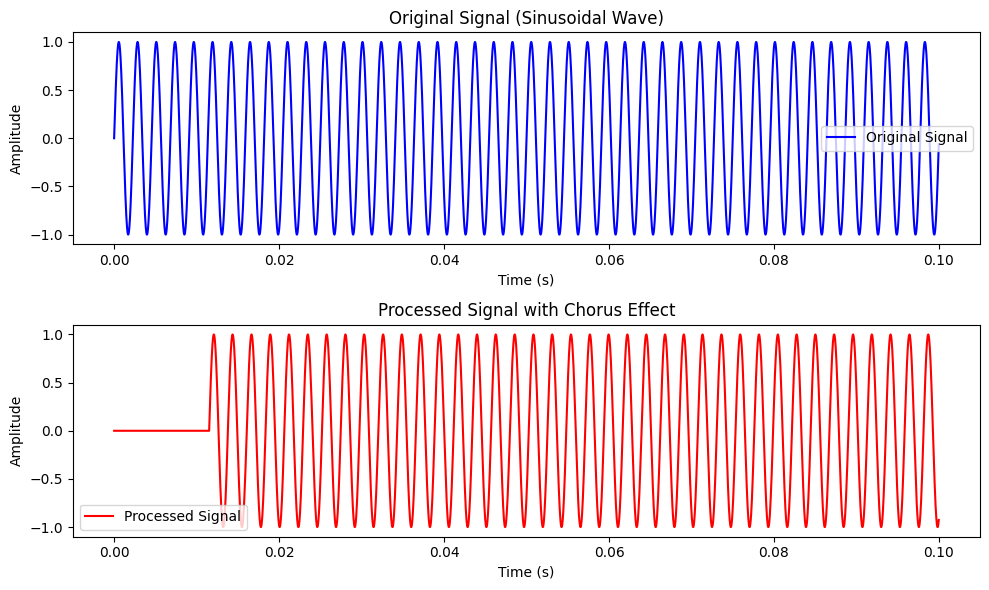

In [74]:
import numpy as np
import matplotlib.pyplot as plt

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, *args, wet_dry=1):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, args, wet_dry))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    @staticmethod
    def delay_system(input_signal, base_delay_samples, lfo_signal=None, lfo_depth=0):
        output_signal = np.zeros_like(input_signal)
        max_delay = base_delay_samples + int(lfo_depth * np.max(np.abs(lfo_signal))) if lfo_signal is not None else base_delay_samples
        buffer = np.zeros(len(input_signal) + max_delay)
        buffer[:len(input_signal)] = input_signal
        
        for i in range(len(input_signal)):
            delay = base_delay_samples
            if lfo_signal is not None:
                delay += int(lfo_depth * lfo_signal[i])
            if delay < 0:
                delay = 0
            output_signal[i] = input_signal[i] + buffer[i + delay]
            buffer[i + delay] = output_signal[i]

        return output_signal
    
    @staticmethod
    def phaser(audio, sample_rate, *args):
        # Unpack args
        rate = args[0] if len(args) > 0 else 0.5
        depth = args[1] if len(args) > 1 else 1
        feedback = args[2] if len(args) > 2 else 0.5
        n_stages = args[3] if len(args) > 3 else 4

        lfo = depth * np.sin(2 * np.pi * rate * np.arange(len(audio)) / sample_rate) 
        # Precalculate all possible delays based on the LFO
        max_delay = int(sample_rate / 4)
        all_delays = np.round((0.5 + 0.5 * lfo) * max_delay).astype(int)

        allpass_g = feedback

        for stage in range(n_stages):  
            # Create coefficients for the allpass filter
            a0 = (1 - allpass_g) / (1 + allpass_g)
            b = [a0, 1]
            a = [1, a0]

            # Apply allpass filter with the corresponding delay for each sample
            filtered_audio = np.zeros_like(audio)  # Initialize the filtered audio array
            for i, delay in enumerate(all_delays):
                delayed_sample = audio[max(0, i - delay)]
                filtered_audio[i] = lfilter(b, a, [delayed_sample])[0]

            # Mix the filtered signal with the original signal
            audio += filtered_audio

        return audio / n_stages
    
    @staticmethod
    def flanger(signal, sample_rate, delay, depth, rate, feedback=0):
        """
        Flanger effect.

        Parameters:
            signal (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delay (float): Base delay time in seconds.
            depth (float): Depth of modulation in seconds.
            rate (float): Rate of LFO in Hz.
            feedback (float): Feedback amount.

        Returns:
            numpy array: Audio signal with flanger effect.
        """
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = depth_samples * (1 + np.sin(2 * np.pi * rate * np.arange(N) / sample_rate)) / 2
        flanged_signal = np.zeros(N)
        feedback_buffer = np.zeros(N)

        for n in range(N):
            delay_n = int(lfo[n])
            if n - delay_samples - delay_n < 0:
                flanged_signal[n] = signal[n]
            else:
                flanged_signal[n] = signal[n] + feedback * feedback_buffer[n - delay_samples - delay_n]
                feedback_buffer[n] = flanged_signal[n]

        return flanged_signal    
    
    @staticmethod
    def chorus(signal, sample_rate, delay, depth, rate, num_voices=3, spread=0.002):
        """
        Chorus effect.

        Parameters:
            signal (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delay (float): Base delay time in seconds.
            depth (float): Depth of modulation in seconds.
            rate (float): Rate of LFO in Hz.
            num_voices (int): Number of voices in the chorus (default is 3).
            spread (float): Spread between voices (default is 0.002 seconds).

        Returns:
            numpy array: Audio signal with chorus effect.
        """
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = np.zeros((num_voices, N))

        for i in range(num_voices):
            lfo[i] = depth_samples * (1 + np.sin(2 * np.pi * (rate + i * spread) * np.arange(N) / sample_rate)) / 2

        chorus_signal = np.zeros(N)
        for i in range(N):
            for j in range(num_voices):
                delay_n = int(lfo[j, i])
                if i - delay_samples - delay_n >= 0:
                    chorus_signal[i] += signal[i - delay_samples - delay_n]
            chorus_signal[i] /= num_voices

        return chorus_signal
    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, args, wet_dry in self.effects:
            if wet_dry == 1:
                output_signal = effect_func(output_signal, *args)
        return output_signal
    
    @staticmethod
    def generate_lfo(sample_rate, duration, frequency, depth):
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        lfo_signal = np.sin(2 * np.pi * frequency * t) * depth
        return lfo_signal





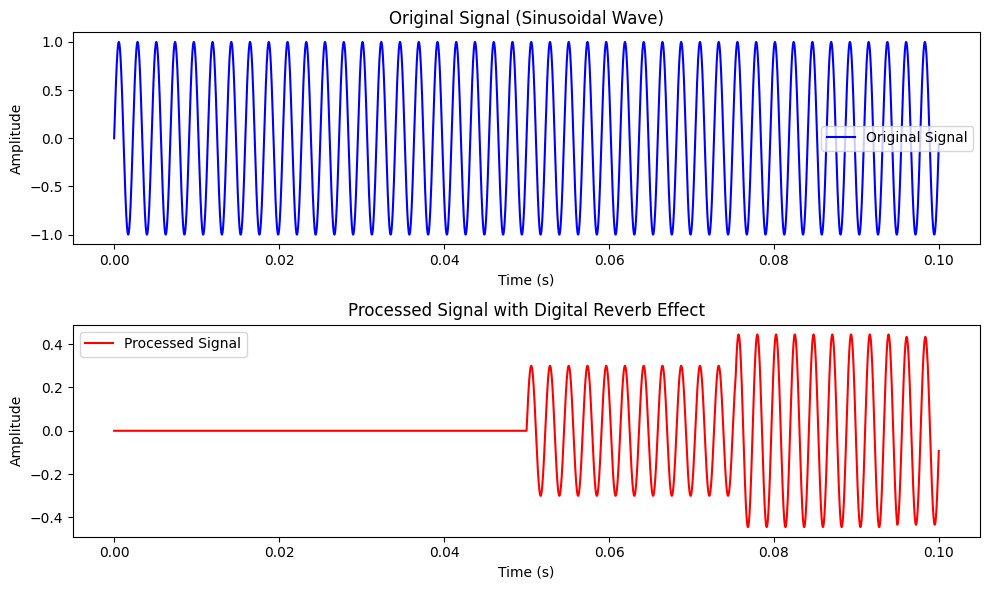

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, *args, wet_dry=1):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, args, wet_dry))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    @staticmethod
    def delay_system(input_signal, base_delay_samples, lfo_signal=None, lfo_depth=0):
        output_signal = np.zeros_like(input_signal)
        max_delay = base_delay_samples + int(lfo_depth * np.max(np.abs(lfo_signal))) if lfo_signal is not None else base_delay_samples
        buffer = np.zeros(len(input_signal) + max_delay)
        buffer[:len(input_signal)] = input_signal
        
        for i in range(len(input_signal)):
            delay = base_delay_samples
            if lfo_signal is not None:
                delay += int(lfo_depth * lfo_signal[i])
            if delay < 0:
                delay = 0
            output_signal[i] = input_signal[i] + buffer[i + delay]
            buffer[i + delay] = output_signal[i]

        return output_signal
    
    @staticmethod
    def phaser(audio, sample_rate, *args):
        # Unpack args
        rate = args[0] if len(args) > 0 else 0.5
        depth = args[1] if len(args) > 1 else 1
        feedback = args[2] if len(args) > 2 else 0.5
        n_stages = args[3] if len(args) > 3 else 4

        lfo = depth * np.sin(2 * np.pi * rate * np.arange(len(audio)) / sample_rate) 
        # Precalculate all possible delays based on the LFO
        max_delay = int(sample_rate / 4)
        all_delays = np.round((0.5 + 0.5 * lfo) * max_delay).astype(int)

        allpass_g = feedback

        for stage in range(n_stages):  
            # Create coefficients for the allpass filter
            a0 = (1 - allpass_g) / (1 + allpass_g)
            b = [a0, 1]
            a = [1, a0]

            # Apply allpass filter with the corresponding delay for each sample
            filtered_audio = np.zeros_like(audio)  # Initialize the filtered audio array
            for i, delay in enumerate(all_delays):
                delayed_sample = audio[max(0, i - delay)]
                filtered_audio[i] = lfilter(b, a, [delayed_sample])[0]

            # Mix the filtered signal with the original signal
            audio += filtered_audio

        return audio / n_stages
    
    @staticmethod
    def flanger(signal, sample_rate, delay, depth, rate, feedback=0):
        """
        Flanger effect.

        Parameters:
            signal (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delay (float): Base delay time in seconds.
            depth (float): Depth of modulation in seconds.
            rate (float): Rate of LFO in Hz.
            feedback (float): Feedback amount.

        Returns:
            numpy array: Audio signal with flanger effect.
        """
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = depth_samples * (1 + np.sin(2 * np.pi * rate * np.arange(N) / sample_rate)) / 2
        flanged_signal = np.zeros(N)
        feedback_buffer = np.zeros(N)

        for n in range(N):
            delay_n = int(lfo[n])
            if n - delay_samples - delay_n < 0:
                flanged_signal[n] = signal[n]
            else:
                flanged_signal[n] = signal[n] + feedback * feedback_buffer[n - delay_samples - delay_n]
                feedback_buffer[n] = flanged_signal[n]

        return flanged_signal    
    
    @staticmethod
    def chorus(signal, sample_rate, delay, depth, rate, num_voices=3, spread=0.002):
        """
        Chorus effect.

        Parameters:
            signal (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delay (float): Base delay time in seconds.
            depth (float): Depth of modulation in seconds.
            rate (float): Rate of LFO in Hz.
            num_voices (int): Number of voices in the chorus (default is 3).
            spread (float): Spread between voices (default is 0.002 seconds).

        Returns:
            numpy array: Audio signal with chorus effect.
        """
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = np.zeros((num_voices, N))

        for i in range(num_voices):
            lfo[i] = depth_samples * (1 + np.sin(2 * np.pi * (rate + i * spread) * np.arange(N) / sample_rate)) / 2

        chorus_signal = np.zeros(N)
        for i in range(N):
            for j in range(num_voices):
                delay_n = int(lfo[j, i])
                if i - delay_samples - delay_n >= 0:
                    chorus_signal[i] += signal[i - delay_samples - delay_n]
            chorus_signal[i] /= num_voices

        return chorus_signal
    
    @staticmethod
    def digital_reverb(audio, sample_rate, delays, gains):
        """
        Digital reverb effect.

        Parameters:
            audio (numpy array): Input audio signal.
            sample_rate (int): Sample rate of the audio signal.
            delays (list of int): List of delay times in samples.
            gains (list of float): List of gain coefficients for each delay.

        Returns:
            numpy array: Audio signal with digital reverb effect.
        """
        assert len(delays) == len(gains), "Number of delays must match number of gains"

        # Ensure all pairs of delays have gcd equal to 1
        def gcd(a, b):
            while b:
                a, b = b, a % b
            return a
        
        for i in range(len(delays)):
            for j in range(i + 1, len(delays)):
                assert gcd(delays[i], delays[j]) == 1, f"Delays {delays[i]} and {delays[j]} do not have gcd 1"
        
        reverb_signal = np.zeros_like(audio)
        
        for delay, gain in zip(delays, gains):
            delayed_signal = np.zeros_like(audio)
            for i in range(delay, len(audio)):
                delayed_signal[i] = gain * audio[i - delay]
            reverb_signal += delayed_signal

        return reverb_signal
    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, args, wet_dry in self.effects:
            if wet_dry == 1:
                if effect_func == EffectRack.digital_reverb:
                    delays, gains = args
                    output_signal = effect_func(output_signal, sample_rate, delays, gains)
                else:
                    output_signal = effect_func(output_signal, *args)
        return output_signal

    
    @staticmethod
    def generate_lfo(sample_rate, duration, frequency, depth):
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        lfo_signal = np.sin(2 * np.pi * frequency * t) * depth
        return lfo_signal




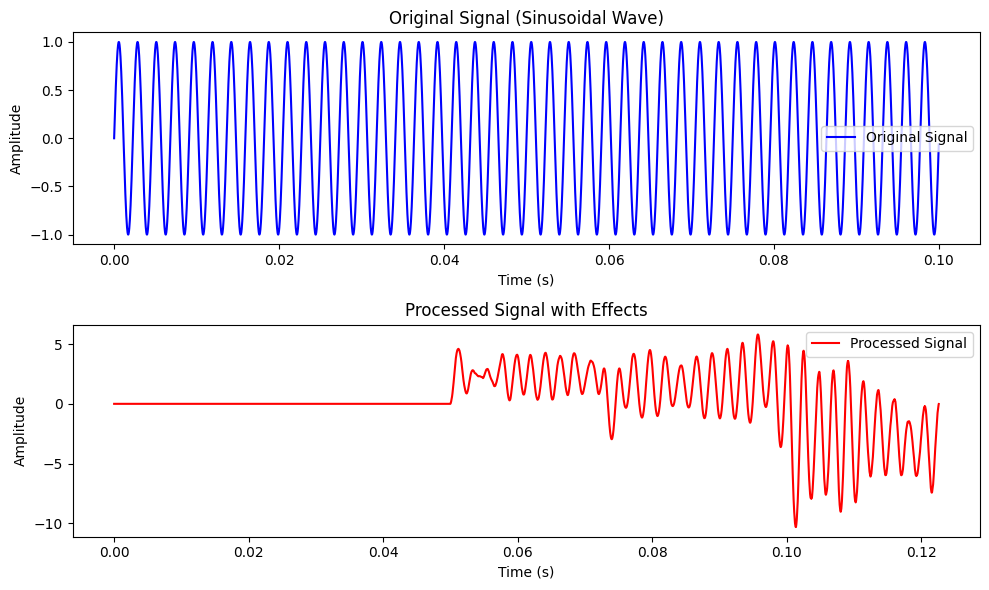

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, fftconvolve

class EffectRack:
    def __init__(self):
        self.effects = []
    
    def add_effect(self, effect_func, *args, wet_dry=1):
        if wet_dry not in [0, 1]:
            raise ValueError("wet_dry must be either 0 or 1")
        self.effects.append((effect_func, args, wet_dry))
    
    def hard_clipping(self, x, T):
        return np.clip(x, -T, T)
    
    def compressor(self, input_signal, threshold, ratio, attack, release, sample_rate, N):
        threshold_linear = 10 ** (threshold / 20.0)
        attack_coeff = np.exp(-1.0 / (attack * sample_rate))
        release_coeff = np.exp(-1.0 / (release * sample_rate))
        output_signal = np.zeros_like(input_signal)
        avg_abs_input = np.zeros_like(input_signal)
        gain = np.ones_like(input_signal)
        
        for i in range(1, len(input_signal)):
            avg_abs_input[i] = np.mean(np.abs(input_signal[max(0, i-N+1):i+1]))
            if avg_abs_input[i] > threshold_linear:
                target_gain = threshold_linear + (avg_abs_input[i] - threshold_linear) / ratio
                if target_gain < gain[i - 1]:
                    gain[i] = attack_coeff * (gain[i - 1] - target_gain) + target_gain
                else:
                    gain[i] = release_coeff * (gain[i - 1] - target_gain) + target_gain
            else:
                gain[i] = 1.0
            output_signal[i] = gain[i] * input_signal[i]
        
        return output_signal
    
    @staticmethod
    def delay_system(input_signal, base_delay_samples, lfo_signal=None, lfo_depth=0):
        output_signal = np.zeros_like(input_signal)
        max_delay = base_delay_samples + int(lfo_depth * np.max(np.abs(lfo_signal))) if lfo_signal is not None else base_delay_samples
        buffer = np.zeros(len(input_signal) + max_delay)
        buffer[:len(input_signal)] = input_signal
        
        for i in range(len(input_signal)):
            delay = base_delay_samples
            if lfo_signal is not None:
                delay += int(lfo_depth * lfo_signal[i])
            if delay < 0:
                delay = 0
            output_signal[i] = input_signal[i] + buffer[i + delay]
            buffer[i + delay] = output_signal[i]

        return output_signal
    
    @staticmethod
    def phaser(audio, sample_rate, *args):
        # Unpack args
        rate = args[0] if len(args) > 0 else 0.5
        depth = args[1] if len(args) > 1 else 1
        feedback = args[2] if len(args) > 2 else 0.5
        n_stages = args[3] if len(args) > 3 else 4

        lfo = depth * np.sin(2 * np.pi * rate * np.arange(len(audio)) / sample_rate) 
        # Precalculate all possible delays based on the LFO
        max_delay = int(sample_rate / 4)
        all_delays = np.round((0.5 + 0.5 * lfo) * max_delay).astype(int)

        allpass_g = feedback

        for stage in range(n_stages):  
            # Create coefficients for the allpass filter
            a0 = (1 - allpass_g) / (1 + allpass_g)
            b = [a0, 1]
            a = [1, a0]

            # Apply allpass filter with the corresponding delay for each sample
            filtered_audio = np.zeros_like(audio)  # Initialize the filtered audio array
            for i, delay in enumerate(all_delays):
                delayed_sample = audio[max(0, i - delay)]
                filtered_audio[i] = lfilter(b, a, [delayed_sample])[0]

            # Mix the filtered signal with the original signal
            audio += filtered_audio

        return audio / n_stages
    
    @staticmethod
    def flanger(signal, sample_rate, delay, depth, rate, feedback=0):
       
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = depth_samples * (1 + np.sin(2 * np.pi * rate * np.arange(N) / sample_rate)) / 2
        flanged_signal = np.zeros(N)
        feedback_buffer = np.zeros(N)

        for n in range(N):
            delay_n = int(lfo[n])
            if n - delay_samples - delay_n < 0:
                flanged_signal[n] = signal[n]
            else:
                flanged_signal[n] = signal[n] + feedback * feedback_buffer[n - delay_samples - delay_n]
                feedback_buffer[n] = flanged_signal[n]

        return flanged_signal    
    
    @staticmethod
    def chorus(signal, sample_rate, delay, depth, rate, num_voices=3, spread=0.002):
       
        N = len(signal)
        delay_samples = int(sample_rate * delay)
        depth_samples = int(sample_rate * depth)
        lfo = np.zeros((num_voices, N))

        for i in range(num_voices):
            lfo[i] = depth_samples * (1 + np.sin(2 * np.pi * (rate + i * spread) * np.arange(N) / sample_rate)) / 2

        chorus_signal = np.zeros(N)
        for i in range(N):
            for j in range(num_voices):
                delay_n = int(lfo[j, i])
                if i - delay_samples - delay_n >= 0:
                    chorus_signal[i] += signal[i - delay_samples - delay_n]
            chorus_signal[i] /= num_voices

        return chorus_signal
    
    @staticmethod
    def digital_reverb(audio, sample_rate, delays, gains):
       
        assert len(delays) == len(gains), "Number of delays must match number of gains"

        # Ensure all pairs of delays have gcd equal to 1
        def gcd(a, b):
            while b:
                a, b = b, a % b
            return a
        
        for i in range(len(delays)):
            for j in range(i + 1, len(delays)):
                assert gcd(delays[i], delays[j]) == 1, f"Delays {delays[i]} and {delays[j]} do not have gcd 1"
        
        reverb_signal = np.zeros_like(audio)
        
        for delay, gain in zip(delays, gains):
            delayed_signal = np.zeros_like(audio)
            for i in range(delay, len(audio)):
                delayed_signal[i] = gain * audio[i - delay]
            reverb_signal += delayed_signal

        return reverb_signal
    
    @staticmethod
    def apply_convolution_reverb(input_signal, impulse_response):
  
        reverb_audio = fftconvolve(input_signal, impulse_response, mode='full')
        return reverb_audio
    
    def apply_effects(self, input_signal):
        output_signal = input_signal
        for effect_func, args, wet_dry in self.effects:
            if wet_dry == 1:
                if effect_func == EffectRack.digital_reverb:
                    delays, gains = args
                    output_signal = effect_func(output_signal, sample_rate, delays, gains)
                elif effect_func == self.apply_convolution_reverb:
                    impulse_response, = args
                    output_signal = effect_func(output_signal, impulse_response)
                else:
                    output_signal = effect_func(output_signal, *args)
        return output_signal
    
    @staticmethod
    def generate_lfo(sample_rate, duration, frequency, depth):
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        lfo_signal = np.sin(2 * np.pi * frequency * t) * depth
        return lfo_signal


